In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications import DenseNet121, VGG16, ResNet50, InceptionV3
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


# 1. KAGGLE DATASET PATHS


# Kaggle auto-mounts dataset here
BASE_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"

train_dir = os.path.join(BASE_DIR, "train")
test_dir = os.path.join(BASE_DIR, "test")
val_dir = os.path.join(BASE_DIR, "val")

# Verify paths exist
print("\nVerifying dataset paths:")
print(f"Train dir exists: {os.path.exists(train_dir)}")
print(f"Test dir exists: {os.path.exists(test_dir)}")
print(f"Val dir exists: {os.path.exists(val_dir)}")


# 2. DATA EXPLORATION


print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)

print("\nTrain set:")
num_pneumonia_train = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal_train = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"  PNEUMONIA: {num_pneumonia_train}")
print(f"  NORMAL: {num_normal_train}")
print(f"  Total: {num_pneumonia_train + num_normal_train}")
print(f"  Imbalance ratio: {num_pneumonia_train/num_normal_train:.2f}:1")

print("\nTest set:")
num_pneumonia_test = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
num_normal_test = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
print(f"  PNEUMONIA: {num_pneumonia_test}")
print(f"  NORMAL: {num_normal_test}")
print(f"  Total: {num_pneumonia_test + num_normal_test}")

print("\nValidation set:")
num_pneumonia_val = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
num_normal_val = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
print(f"  PNEUMONIA: {num_pneumonia_val}")
print(f"  NORMAL: {num_normal_val}")
print(f"  Total: {num_pneumonia_val + num_normal_val}")


# 3. DATA PREPROCESSING (NO DATA LEAKAGE)


IMG_SIZE = 224
BATCH_SIZE = 8

# Training: augmentation + rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Test/Val: only rescaling (no augmentation, no data leakage)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

print(f"\nClass mapping: {train_generator.class_indices}")


# 4. CLASS WEIGHTS


total_train = num_normal_train + num_pneumonia_train
weight_for_0 = total_train / (2 * num_normal_train)
weight_for_1 = total_train / (2 * num_pneumonia_train)

class_weight = {0: weight_for_0, 1: weight_for_1}
print(f"\nClass weights: NORMAL={weight_for_0:.3f}, PNEUMONIA={weight_for_1:.3f}")


# 5. HELPER FUNCTIONS


def build_transfer_model(base_model, model_name):
    """Build consistent architecture on top of base model"""
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions, name=model_name)
    return model

def compile_model(model, learning_rate=0.001):
    """Compile with medical imaging metrics"""
    metrics = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=metrics
    )
    return model

def get_callbacks(model_name):
    """Training callbacks"""
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]

def plot_training_history(history, model_name):
    """Plot training metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 0].set_title(f'{model_name} - Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(history.history['accuracy'], label='Train Acc')
    axes[0, 1].plot(history.history['val_accuracy'], label='Val Acc')
    axes[0, 1].set_title(f'{model_name} - Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].plot(history.history['auc'], label='Train AUC')
    axes[1, 0].plot(history.history['val_auc'], label='Val AUC')
    axes[1, 0].set_title(f'{model_name} - AUC')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
    axes[1, 1].set_title(f'{model_name} - Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_gen, model_name):
    """Comprehensive evaluation"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {model_name}")
    print(f"{'='*60}")
    
    test_gen.reset()
    y_pred_proba = model.predict(test_gen, verbose=1)
    y_true = test_gen.classes
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_gen, verbose=0)
    
    print(f"\nTest Metrics:")
    print(f"  Accuracy:  {test_acc*100:.2f}%")
    print(f"  Precision: {test_precision*100:.2f}%")
    print(f"  Recall:    {test_recall*100:.2f}%")
    print(f"  AUC:       {test_auc:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    print(f"\nClinical Metrics:")
    print(f"  Sensitivity: {sensitivity*100:.2f}%")
    print(f"  Specificity: {specificity*100:.2f}%")
    
    print(f"\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC={test_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Confusion Matrix Heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'accuracy': test_acc,
        'precision': test_precision,
        'recall': test_recall,
        'auc': test_auc,
        'specificity': specificity,
        'sensitivity': sensitivity
    }


ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (/usr/local/lib/python3.11/dist-packages/keras/api/preprocessing/image/__init__.py)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import DenseNet121, VGG16, ResNet50, InceptionV3
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


# 1. KAGGLE DATASET PATHS


# Kaggle auto-mounts dataset here
BASE_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"

train_dir = os.path.join(BASE_DIR, "train")
test_dir = os.path.join(BASE_DIR, "test")
val_dir = os.path.join(BASE_DIR, "val")

# Verify paths exist
print("\nVerifying dataset paths:")
print(f"Train dir exists: {os.path.exists(train_dir)}")
print(f"Test dir exists: {os.path.exists(test_dir)}")
print(f"Val dir exists: {os.path.exists(val_dir)}")


# 2. DATA EXPLORATION


print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)

print("\nTrain set:")
num_pneumonia_train = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal_train = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"  PNEUMONIA: {num_pneumonia_train}")
print(f"  NORMAL: {num_normal_train}")
print(f"  Total: {num_pneumonia_train + num_normal_train}")
print(f"  Imbalance ratio: {num_pneumonia_train/num_normal_train:.2f}:1")

print("\nTest set:")
num_pneumonia_test = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
num_normal_test = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
print(f"  PNEUMONIA: {num_pneumonia_test}")
print(f"  NORMAL: {num_normal_test}")
print(f"  Total: {num_pneumonia_test + num_normal_test}")

print("\nValidation set:")
num_pneumonia_val = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
num_normal_val = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
print(f"  PNEUMONIA: {num_pneumonia_val}")
print(f"  NORMAL: {num_normal_val}")
print(f"  Total: {num_pneumonia_val + num_normal_val}")


# 3. DATA PREPROCESSING (NO DATA LEAKAGE)


IMG_SIZE = 224
BATCH_SIZE = 8

# Training: augmentation + rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Test/Val: only rescaling (no augmentation, no data leakage)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

print(f"\nClass mapping: {train_generator.class_indices}")


# 4. CLASS WEIGHTS


total_train = num_normal_train + num_pneumonia_train
weight_for_0 = total_train / (2 * num_normal_train)
weight_for_1 = total_train / (2 * num_pneumonia_train)

class_weight = {0: weight_for_0, 1: weight_for_1}
print(f"\nClass weights: NORMAL={weight_for_0:.3f}, PNEUMONIA={weight_for_1:.3f}")


# 5. HELPER FUNCTIONS


def build_transfer_model(base_model, model_name):
    """Build consistent architecture on top of base model"""
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions, name=model_name)
    return model

def compile_model(model, learning_rate=0.001):
    """Compile with medical imaging metrics"""
    metrics = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=metrics
    )
    return model

def get_callbacks(model_name):
    """Training callbacks"""
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]

def plot_training_history(history, model_name):
    """Plot training metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 0].set_title(f'{model_name} - Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(history.history['accuracy'], label='Train Acc')
    axes[0, 1].plot(history.history['val_accuracy'], label='Val Acc')
    axes[0, 1].set_title(f'{model_name} - Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].plot(history.history['auc'], label='Train AUC')
    axes[1, 0].plot(history.history['val_auc'], label='Val AUC')
    axes[1, 0].set_title(f'{model_name} - AUC')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
    axes[1, 1].set_title(f'{model_name} - Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_gen, model_name):
    """Comprehensive evaluation"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {model_name}")
    print(f"{'='*60}")
    
    test_gen.reset()
    y_pred_proba = model.predict(test_gen, verbose=1)
    y_true = test_gen.classes
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_gen, verbose=0)
    
    print(f"\nTest Metrics:")
    print(f"  Accuracy:  {test_acc*100:.2f}%")
    print(f"  Precision: {test_precision*100:.2f}%")
    print(f"  Recall:    {test_recall*100:.2f}%")
    print(f"  AUC:       {test_auc:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    print(f"\nClinical Metrics:")
    print(f"  Sensitivity: {sensitivity*100:.2f}%")
    print(f"  Specificity: {specificity*100:.2f}%")
    
    print(f"\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC={test_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Confusion Matrix Heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'accuracy': test_acc,
        'precision': test_precision,
        'recall': test_recall,
        'auc': test_auc,
        'specificity': specificity,
        'sensitivity': sensitivity
    }

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

Verifying dataset paths:
Train dir exists: True
Test dir exists: True
Val dir exists: True

DATASET STATISTICS

Train set:
  PNEUMONIA: 3876
  NORMAL: 1342
  Total: 5218
  Imbalance ratio: 2.89:1

Test set:
  PNEUMONIA: 390
  NORMAL: 234
  Total: 624

Validation set:
  PNEUMONIA: 9
  NORMAL: 9
  Total: 18
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}

Class weights: NORMAL=1.944, PNEUMONIA=0.673



TRAINING CUSTOM CNN


I0000 00:00:1759635941.777152      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759635941.777857      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/15


I0000 00:00:1759635950.631185     125 service.cc:148] XLA service 0x7f7a38007a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759635950.631896     125 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759635950.631918     125 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759635951.368770     125 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/652 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.4375 - auc: 0.0962 - loss: 27.4565 - precision: 0.8636 - recall: 0.4952      

I0000 00:00:1759635959.466475     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


652/652 ━━━━━━━━━━━━━━━━━━━━ 135s 184ms/step - accuracy: 0.7404 - auc: 0.7829 - loss: 4.1484 - precision: 0.9059 - recall: 0.7288 - val_accuracy: 0.5625 - val_auc: 0.7812 - val_loss: 0.5152 - val_precision: 0.6000 - val_recall: 0.3750 - learning_rate: 0.0010
Epoch 2/15
652/652 ━━━━━━━━━━━━━━━━━━━━ 92s 141ms/step - accuracy: 0.6463 - auc: 0.8337 - loss: 0.6621 - precision: 0.9493 - recall: 0.5638 - val_accuracy: 0.5000 - val_auc: 0.5938 - val_loss: 2.2682 - val_precision: 0.5000 - val_recall: 0.2500 - learning_rate: 0.0010
Epoch 3/15
652/652 ━━━━━━━━━━━━━━━━━━━━ 91s 140ms/step - accuracy: 0.7632 - auc: 0.9196 - loss: 0.3773 - precision: 0.9742 - recall: 0.7008 - val_accuracy: 0.5625 - val_auc: 0.6250 - val_loss: 1.5344 - val_precision: 0.5556 - val_recall: 0.6250 - learning_rate: 0.0010
Epoch 4/15
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7160 - auc: 0.8621 - loss: 0.7436 - precision: 0.9511 - recall: 0.6517
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.000500000

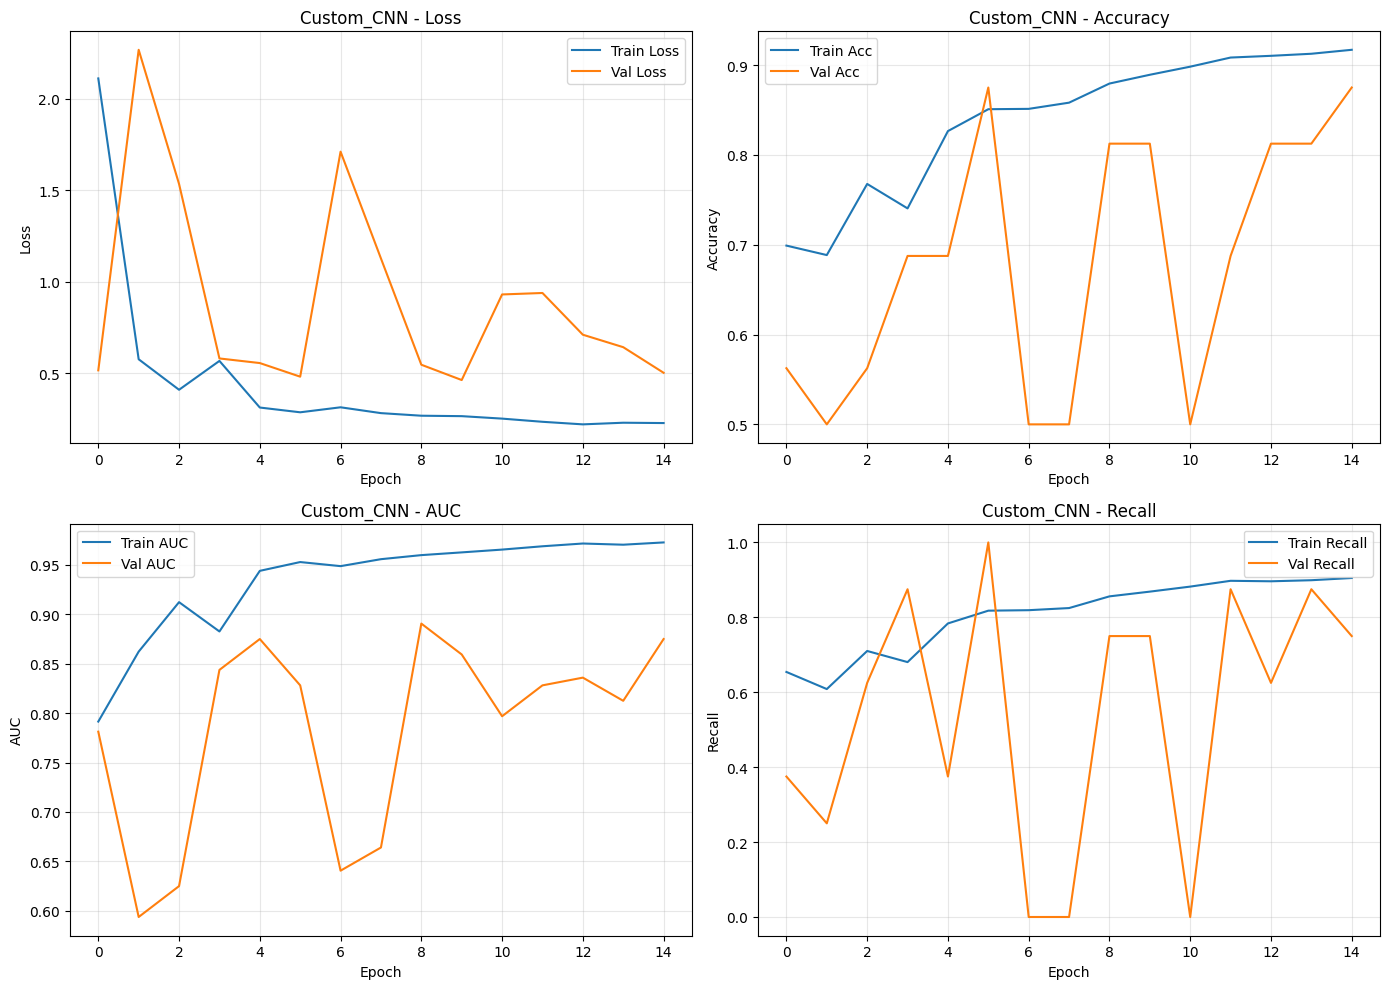


EVALUATING Custom_CNN
624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step

Test Metrics:
  Accuracy:  87.50%
  Precision: 90.41%
  Recall:    89.49%
  AUC:       0.9393

Clinical Metrics:
  Sensitivity: 89.49%
  Specificity: 84.19%

Confusion Matrix:
[[197  37]
 [ 41 349]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.83      0.84      0.83       234
   PNEUMONIA       0.90      0.89      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624



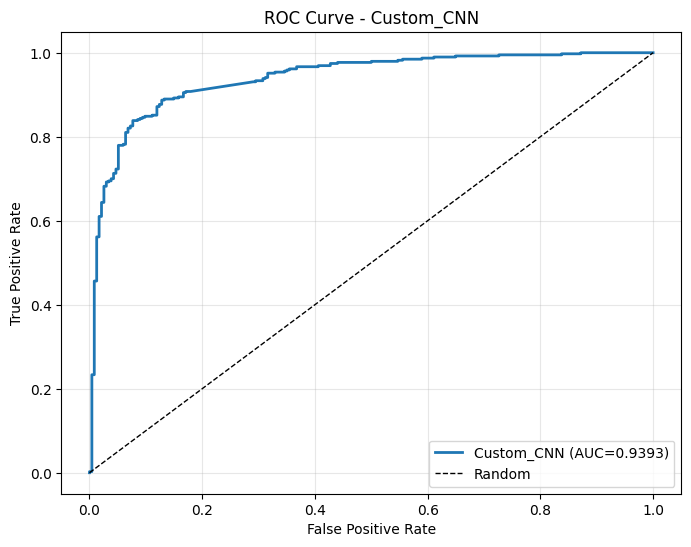

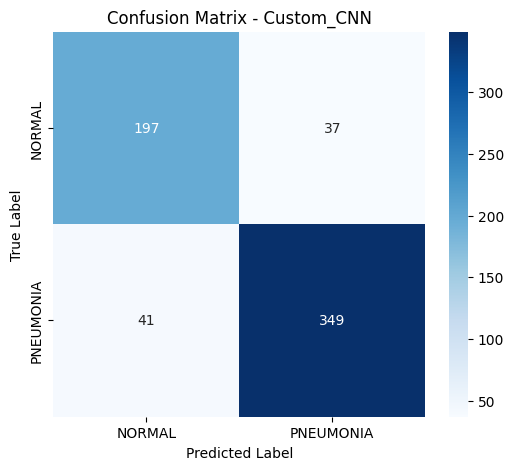

In [ ]:
results = {}


# MODEL 1: CUSTOM CNN


print("\n" + "="*60)
print("TRAINING CUSTOM CNN")
print("="*60)

custom_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
], name='Custom_CNN')

custom_cnn = compile_model(custom_cnn)

history_cnn = custom_cnn.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=get_callbacks('Custom_CNN'),
    verbose=1
)

plot_training_history(history_cnn, 'Custom_CNN')
results['Custom_CNN'] = evaluate_model(custom_cnn, test_generator, 'Custom_CNN')

In [6]:
# Add this cell and run it:
custom_cnn.save('custom_cnn_model.keras')
print("Model saved!")

Model saved!


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import DenseNet121, VGG16, ResNet50, InceptionV3
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [4]:
BASE_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"
train_dir = os.path.join(BASE_DIR, "train")
test_dir = os.path.join(BASE_DIR, "test")
val_dir = os.path.join(BASE_DIR, "val")

# Get counts
num_pneumonia_train = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal_train = len(os.listdir(os.path.join(train_dir, 'NORMAL')))

In [5]:
IMG_SIZE = 224
BATCH_SIZE = 8

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=True, seed=42
)
validation_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=1,
    class_mode='binary', shuffle=False
)

# Class weights
total_train = num_normal_train + num_pneumonia_train
weight_for_0 = total_train / (2 * num_normal_train)
weight_for_1 = total_train / (2 * num_pneumonia_train)
class_weight = {0: weight_for_0, 1: weight_for_1}

# Results dict
results = {}

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
def build_transfer_model(base_model, model_name):
    """Build consistent architecture on top of base model"""
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions, name=model_name)
    return model

def compile_model(model, learning_rate=0.001):
    """Compile with medical imaging metrics"""
    metrics = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=metrics
    )
    return model

def get_callbacks(model_name):
    """Training callbacks"""
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]

def plot_training_history(history, model_name):
    """Plot training metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 0].set_title(f'{model_name} - Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(history.history['accuracy'], label='Train Acc')
    axes[0, 1].plot(history.history['val_accuracy'], label='Val Acc')
    axes[0, 1].set_title(f'{model_name} - Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].plot(history.history['auc'], label='Train AUC')
    axes[1, 0].plot(history.history['val_auc'], label='Val AUC')
    axes[1, 0].set_title(f'{model_name} - AUC')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
    axes[1, 1].set_title(f'{model_name} - Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_gen, model_name):
    """Comprehensive evaluation"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {model_name}")
    print(f"{'='*60}")
    
    test_gen.reset()
    y_pred_proba = model.predict(test_gen, verbose=1)
    y_true = test_gen.classes
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_gen, verbose=0)
    
    print(f"\nTest Metrics:")
    print(f"  Accuracy:  {test_acc*100:.2f}%")
    print(f"  Precision: {test_precision*100:.2f}%")
    print(f"  Recall:    {test_recall*100:.2f}%")
    print(f"  AUC:       {test_auc:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    print(f"\nClinical Metrics:")
    print(f"  Sensitivity: {sensitivity*100:.2f}%")
    print(f"  Specificity: {specificity*100:.2f}%")
    
    print(f"\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC={test_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Confusion Matrix Heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'accuracy': test_acc,
        'precision': test_precision,
        'recall': test_recall,
        'auc': test_auc,
        'specificity': specificity,
        'sensitivity': sensitivity
    }

In [ ]:
print("\n" + "="*60)
print("TRAINING CUSTOM CNN")
print("="*60)

custom_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
], name='Custom_CNN')

custom_cnn = compile_model(custom_cnn)

history_cnn = custom_cnn.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=get_callbacks('Custom_CNN'),
    verbose=1
)

plot_training_history(history_cnn, 'Custom_CNN')
results['Custom_CNN'] = evaluate_model(custom_cnn, test_generator, 'Custom_CNN')


TRAINING CUSTOM CNN


I0000 00:00:1759679435.931395      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759679435.932123      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/10


I0000 00:00:1759679446.298055     124 service.cc:148] XLA service 0x7bf0f8008df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759679446.299625     124 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759679446.299649     124 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759679447.176145     124 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/652 ━━━━━━━━━━━━━━━━━━━━ 38s 59ms/step - accuracy: 0.5312 - auc: 0.2667 - loss: 1.0184 - precision: 0.8333 - recall: 0.5810       

I0000 00:00:1759679456.692493     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


652/652 ━━━━━━━━━━━━━━━━━━━━ 155s 211ms/step - accuracy: 0.7614 - auc: 0.8016 - loss: 3.8985 - precision: 0.9128 - recall: 0.7541 - val_accuracy: 0.5000 - val_auc: 0.5625 - val_loss: 12.6881 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 97s 149ms/step - accuracy: 0.7247 - auc: 0.8557 - loss: 0.7361 - precision: 0.9409 - recall: 0.6714 - val_accuracy: 0.1875 - val_auc: 0.1094 - val_loss: 7.5214 - val_precision: 0.1429 - val_recall: 0.1250 - learning_rate: 0.0010
Epoch 3/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 95s 145ms/step - accuracy: 0.7957 - auc: 0.9163 - loss: 0.4444 - precision: 0.9605 - recall: 0.7561 - val_accuracy: 0.6875 - val_auc: 0.7344 - val_loss: 0.6699 - val_precision: 0.6667 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 4/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.8042 - auc: 0.9272 - loss: 0.3630 - precision: 0.9557 - recall: 0.7781 - val_accuracy: 0.3750 - val_auc: 0.5234 - val_loss: 2.2402 - 


TRAINING CUSTOM CNN
Epoch 1/15
652/652 ━━━━━━━━━━━━━━━━━━━━ 113s 155ms/step - accuracy: 0.7544 - auc: 0.7914 - loss: 3.5640 - precision: 0.9012 - recall: 0.7545 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 9.0411 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/15
652/652 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.7104 - auc: 0.8617 - loss: 0.8505 - precision: 0.9383 - recall: 0.6463 - val_accuracy: 0.5000 - val_auc: 0.6875 - val_loss: 3.1735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/15
652/652 ━━━━━━━━━━━━━━━━━━━━ 95s 145ms/step - accuracy: 0.8692 - auc: 0.9246 - loss: 0.3948 - precision: 0.9348 - recall: 0.8853 - val_accuracy: 0.5000 - val_auc: 0.8516 - val_loss: 1.8288 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/15
652/652 ━━━━━━━━━━━━━━━━━━━━ 96s 146ms/step - accuracy: 0.8637 - auc: 0.9195 - loss: 0.4140 - precision: 0.9181 - recall: 0.8970 - val_a

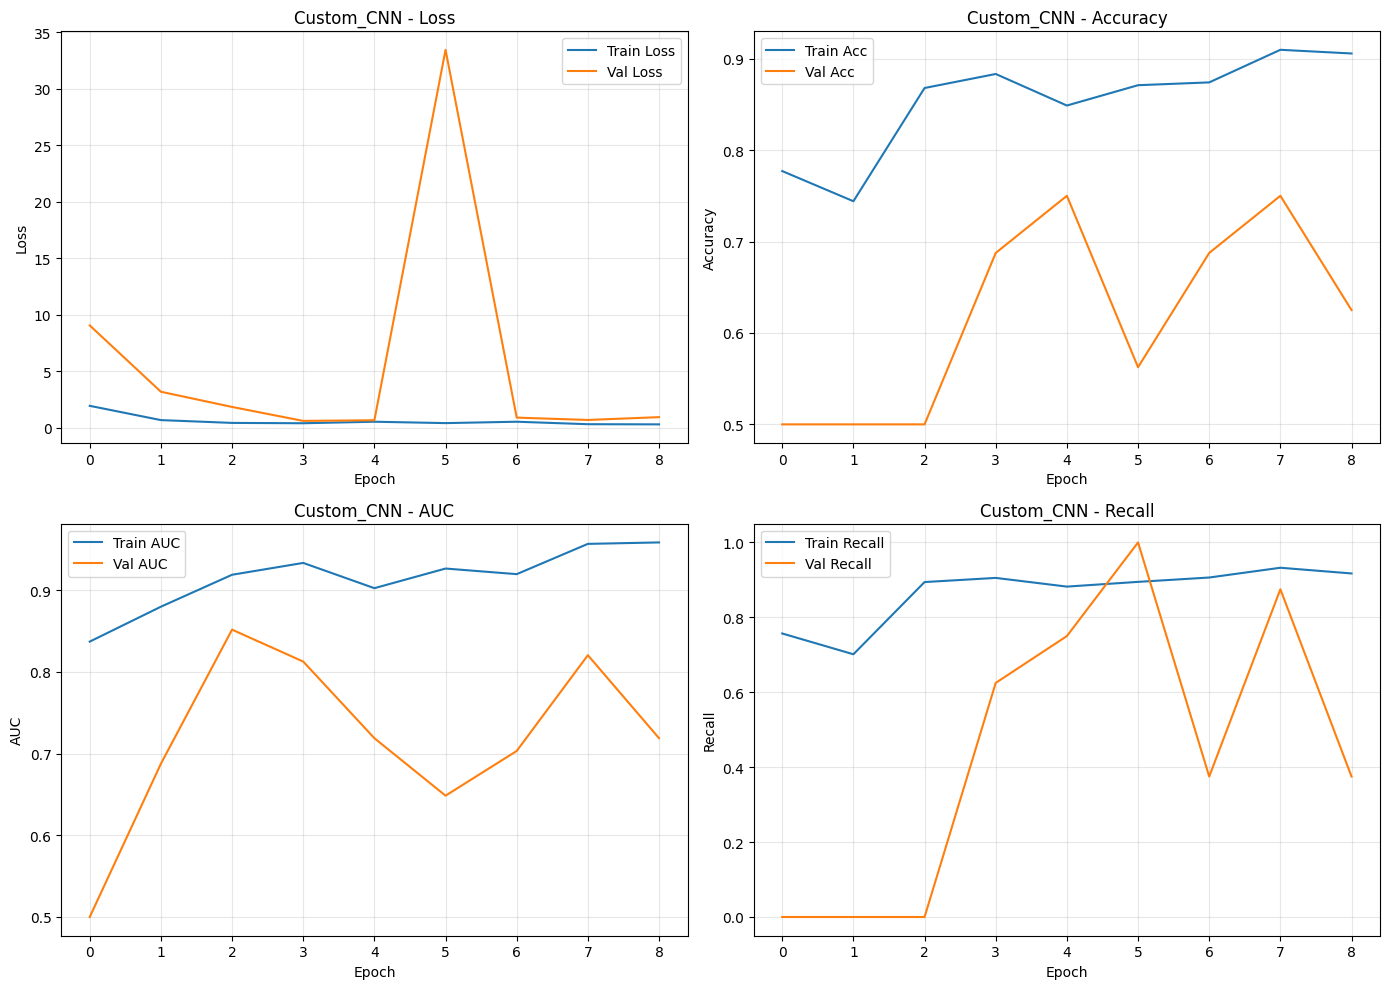


EVALUATING Custom_CNN
624/624 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step

Test Metrics:
  Accuracy:  72.60%
  Precision: 74.50%
  Recall:    85.38%
  AUC:       0.7907

Clinical Metrics:
  Sensitivity: 85.38%
  Specificity: 51.28%

Confusion Matrix:
[[120 114]
 [ 57 333]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.68      0.51      0.58       234
   PNEUMONIA       0.74      0.85      0.80       390

    accuracy                           0.73       624
   macro avg       0.71      0.68      0.69       624
weighted avg       0.72      0.73      0.72       624



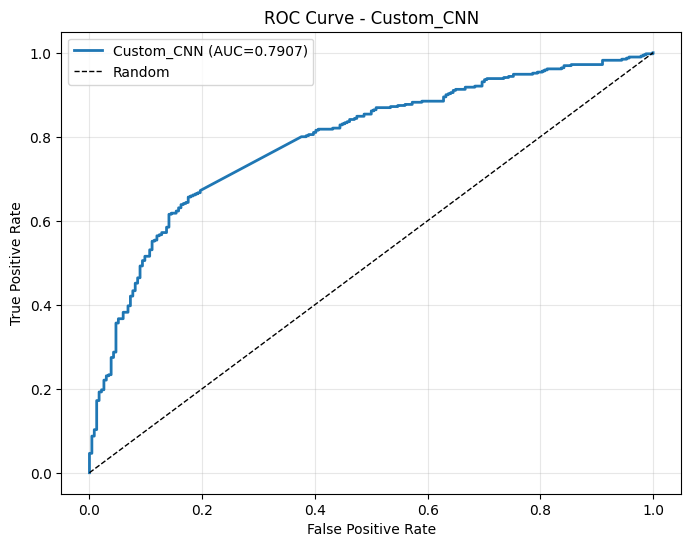

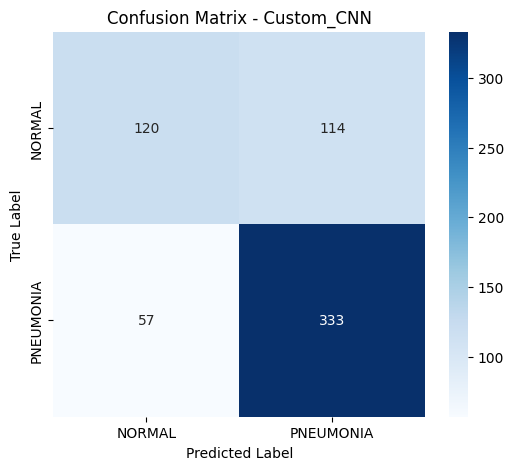

In [8]:
print("\n" + "="*60)
print("TRAINING CUSTOM CNN")
print("="*60)

custom_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
], name='Custom_CNN')

custom_cnn = compile_model(custom_cnn)

history_cnn = custom_cnn.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=get_callbacks('Custom_CNN'),
    verbose=1
)

plot_training_history(history_cnn, 'Custom_CNN')
results['Custom_CNN'] = evaluate_model(custom_cnn, test_generator, 'Custom_CNN')

In [ ]:
print("\n" + "="*60)
print("TRAINING DENSENET121")
print("="*60)

densenet_base = DenseNet121(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

densenet_base.trainable = False
densenet_model = build_transfer_model(densenet_base, 'DenseNet121')
densenet_model = compile_model(densenet_model, learning_rate=0.001)

print("\nPhase 1: Training top layers...")
history_d1 = densenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=get_callbacks('DenseNet121_P1'),
    verbose=1
)

print("\nPhase 2: Fine-tuning...")
densenet_base.trainable = True
for layer in densenet_base.layers[:-20]:
    layer.trainable = False

densenet_model = compile_model(densenet_model, learning_rate=1e-5)

history_d2 = densenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=get_callbacks('DenseNet121_P2'),
    verbose=1
)

for key in history_d1.history.keys():
    history_d1.history[key].extend(history_d2.history[key])

plot_training_history(history_d1, 'DenseNet121')
results['DenseNet121'] = evaluate_model(densenet_model, test_generator, 'DenseNet121')


TRAINING DENSENET121
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Phase 1: Training top layers...
Epoch 1/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 147s 174ms/step - accuracy: 0.8128 - auc: 0.9205 - loss: 0.3779 - precision: 0.9541 - recall: 0.7842 - val_accuracy: 0.8750 - val_auc: 0.9453 - val_loss: 0.3267 - val_precision: 0.8000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 100s 153ms/step - accuracy: 0.8835 - auc: 0.9561 - loss: 0.2703 - precision: 0.9671 - recall: 0.8735 - val_accuracy: 0.9375 - val_auc: 0.9922 - val_loss: 0.2294 - val_precision: 0.8889 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 97s 149ms/step - accuracy: 0.9030 - auc: 0.9673 - loss: 0.2295 - precision: 0.9694 - recall: 0.8976 - val_accuracy: 0.8750 - val_auc: 0.9531 - val_loss: 0.2627 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 4/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 97s 148ms/step - accuracy: 0.9058 - auc: 0.96

In [ ]:
print("\n" + "="*60)
print("TRAINING DENSENET121")
print("="*60)

densenet_base = DenseNet121(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

densenet_base.trainable = False
densenet_model = build_transfer_model(densenet_base, 'DenseNet121')
densenet_model = compile_model(densenet_model, learning_rate=0.001)

print("\nPhase 1: Training top layers...")
history_d1 = densenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=get_callbacks('DenseNet121_P1'),
    verbose=1
)

print("\nPhase 2: Fine-tuning...")
densenet_base.trainable = True
for layer in densenet_base.layers[:-20]:
    layer.trainable = False

densenet_model = compile_model(densenet_model, learning_rate=1e-5)

history_d2 = densenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=get_callbacks('DenseNet121_P2'),
    verbose=1
)

for key in history_d1.history.keys():
    history_d1.history[key].extend(history_d2.history[key])

plot_training_history(history_d1, 'DenseNet121')
results['DenseNet121'] = evaluate_model(densenet_model, test_generator, 'DenseNet121')


TRAINING DENSENET121

Phase 1: Training top layers...
Epoch 1/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 142s 171ms/step - accuracy: 0.8116 - auc: 0.9134 - loss: 0.4029 - precision: 0.9485 - recall: 0.7852 - val_accuracy: 0.8750 - val_auc: 0.9766 - val_loss: 0.2299 - val_precision: 1.0000 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 2/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 96s 148ms/step - accuracy: 0.8945 - auc: 0.9629 - loss: 0.2460 - precision: 0.9698 - recall: 0.8851 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.2367 - val_precision: 1.0000 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 3/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 98s 150ms/step - accuracy: 0.9056 - auc: 0.9707 - loss: 0.2162 - precision: 0.9774 - recall: 0.8933 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.2423 - val_precision: 1.0000 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 4/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 97s 149ms/step - accuracy: 0.9124 - auc: 0.9703 - loss: 0.2142 - precision: 0.9711 - recall: 0.90


TRAINING DENSENET121

Phase 1: Training top layers...
Epoch 1/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 142s 170ms/step - accuracy: 0.8124 - auc: 0.9195 - loss: 0.3883 - precision: 0.9537 - recall: 0.7808 - val_accuracy: 0.8125 - val_auc: 0.9688 - val_loss: 0.3940 - val_precision: 0.8571 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 2/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 99s 152ms/step - accuracy: 0.8827 - auc: 0.9518 - loss: 0.2806 - precision: 0.9659 - recall: 0.8738 - val_accuracy: 0.8125 - val_auc: 0.9297 - val_loss: 0.3994 - val_precision: 0.8571 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 3/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 102s 157ms/step - accuracy: 0.9033 - auc: 0.9662 - loss: 0.2281 - precision: 0.9745 - recall: 0.8951 - val_accuracy: 0.7500 - val_auc: 0.9844 - val_loss: 0.5666 - val_precision: 1.0000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 4/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 97s 148ms/step - accuracy: 0.9053 - auc: 0.9693 - loss: 0.2203 - precision: 0.9780 - recall: 0.8914 

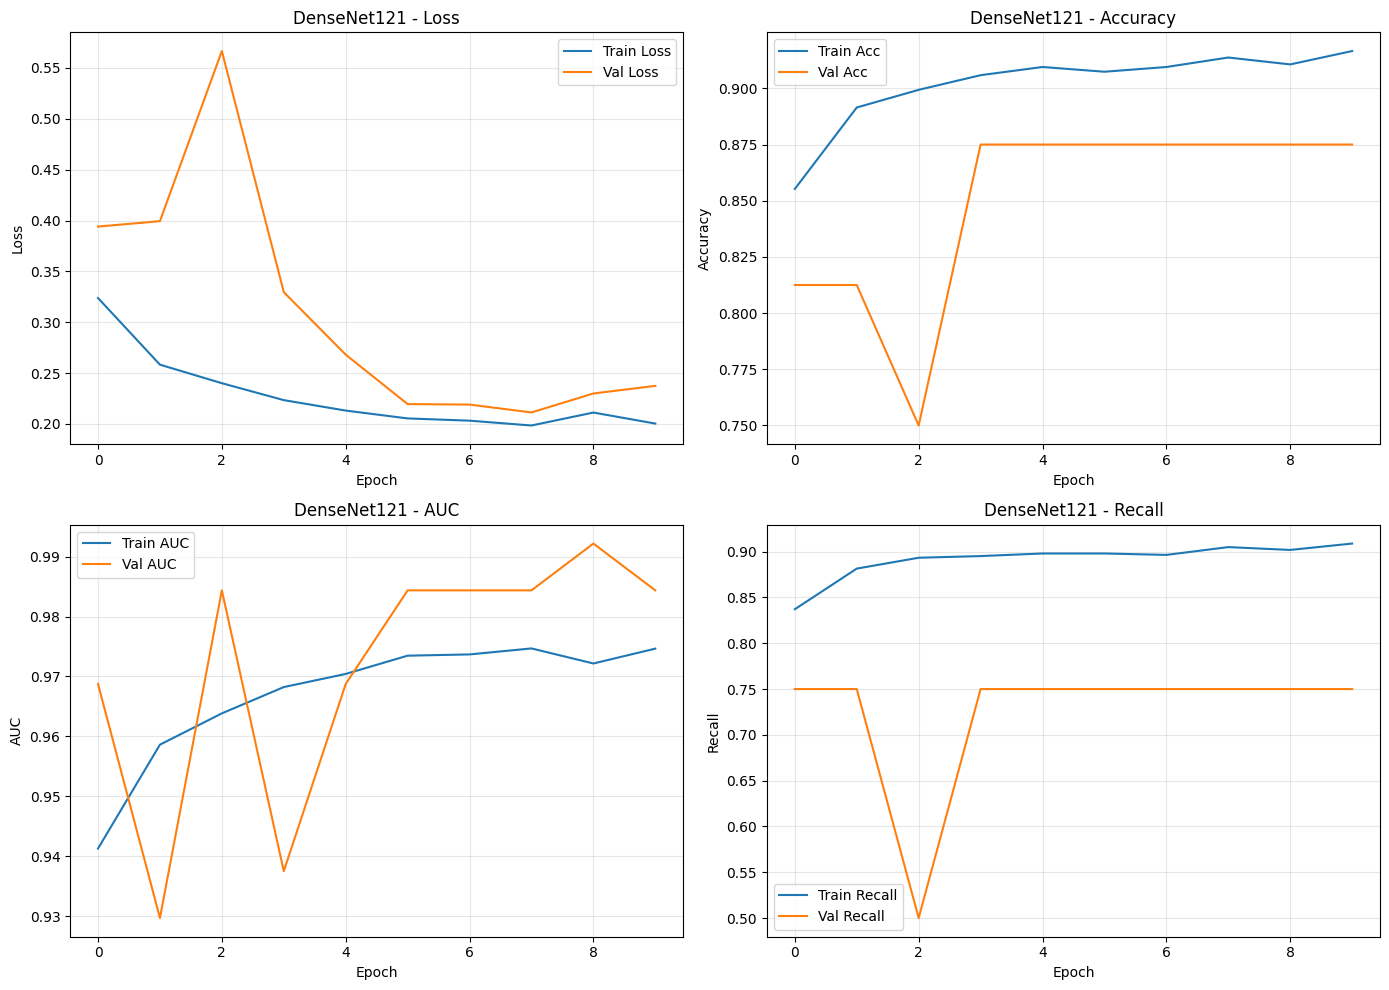


EVALUATING DenseNet121
624/624 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step

Test Metrics:
  Accuracy:  92.47%
  Precision: 93.86%
  Recall:    94.10%
  AUC:       0.9629

Clinical Metrics:
  Sensitivity: 94.10%
  Specificity: 89.74%

Confusion Matrix:
[[210  24]
 [ 23 367]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.90      0.90      0.90       234
   PNEUMONIA       0.94      0.94      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.92      0.92       624
weighted avg       0.92      0.92      0.92       624



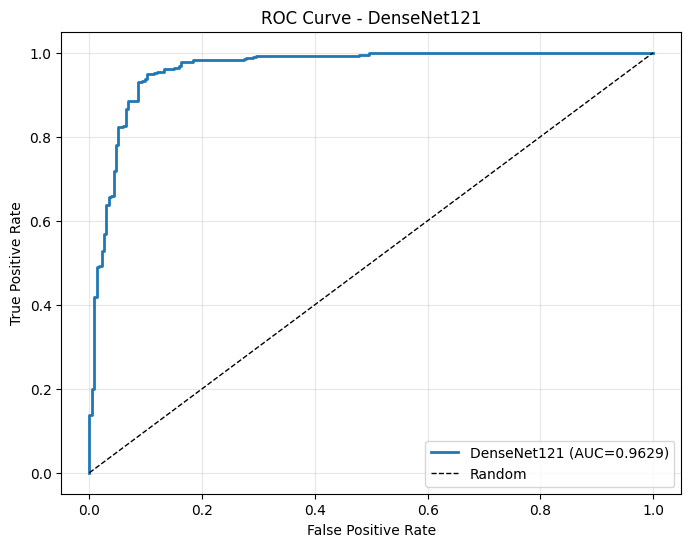

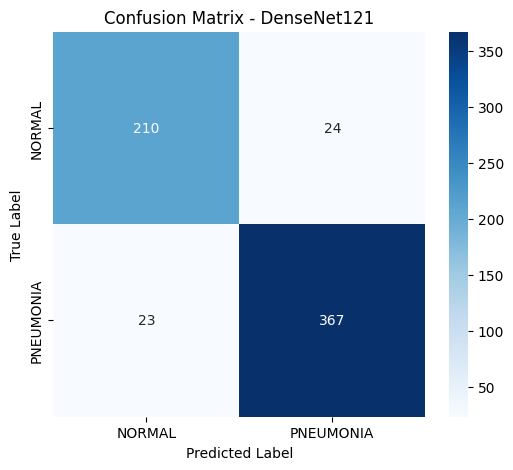

In [16]:
print("\n" + "="*60)
print("TRAINING DENSENET121")
print("="*60)

densenet_base = DenseNet121(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

densenet_base.trainable = False
densenet_model = build_transfer_model(densenet_base, 'DenseNet121')
densenet_model = compile_model(densenet_model, learning_rate=0.001)

print("\nPhase 1: Training top layers...")
history_d1 = densenet_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=get_callbacks('DenseNet121_P1'),
    verbose=1
)

print("\nPhase 2: Fine-tuning...")
densenet_base.trainable = True
for layer in densenet_base.layers[:-20]:
    layer.trainable = False

densenet_model = compile_model(densenet_model, learning_rate=1e-5)

history_d2 = densenet_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=get_callbacks('DenseNet121_P2'),
    verbose=1
)

for key in history_d1.history.keys():
    history_d1.history[key].extend(history_d2.history[key])

plot_training_history(history_d1, 'DenseNet121')
results['DenseNet121'] = evaluate_model(densenet_model, test_generator, 'DenseNet121')


TRAINING VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Phase 1: Training top layers...
Epoch 1/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 122s 171ms/step - accuracy: 0.7952 - auc: 0.8991 - loss: 0.4240 - precision: 0.9498 - recall: 0.7647 - val_accuracy: 0.8125 - val_auc: 0.9375 - val_loss: 0.3934 - val_precision: 0.7273 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 105s 161ms/step - accuracy: 0.8883 - auc: 0.9528 - loss: 0.2777 - precision: 0.9672 - recall: 0.8792 - val_accuracy: 0.8750 - val_auc: 0.9688 - val_loss: 0.2650 - val_precision: 1.0000 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 3/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 104s 159ms/step - accuracy: 0.9028 - auc: 0.9677 - loss: 0.2270 - precision: 0.9756 - recall: 0.8916 - val_accuracy: 0.8125 - val_auc: 0.9531 - val_loss: 0.4033 - val_precision: 0.7273 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 104s 159ms/step - accuracy: 0.9081 - auc: 0.9686 - los

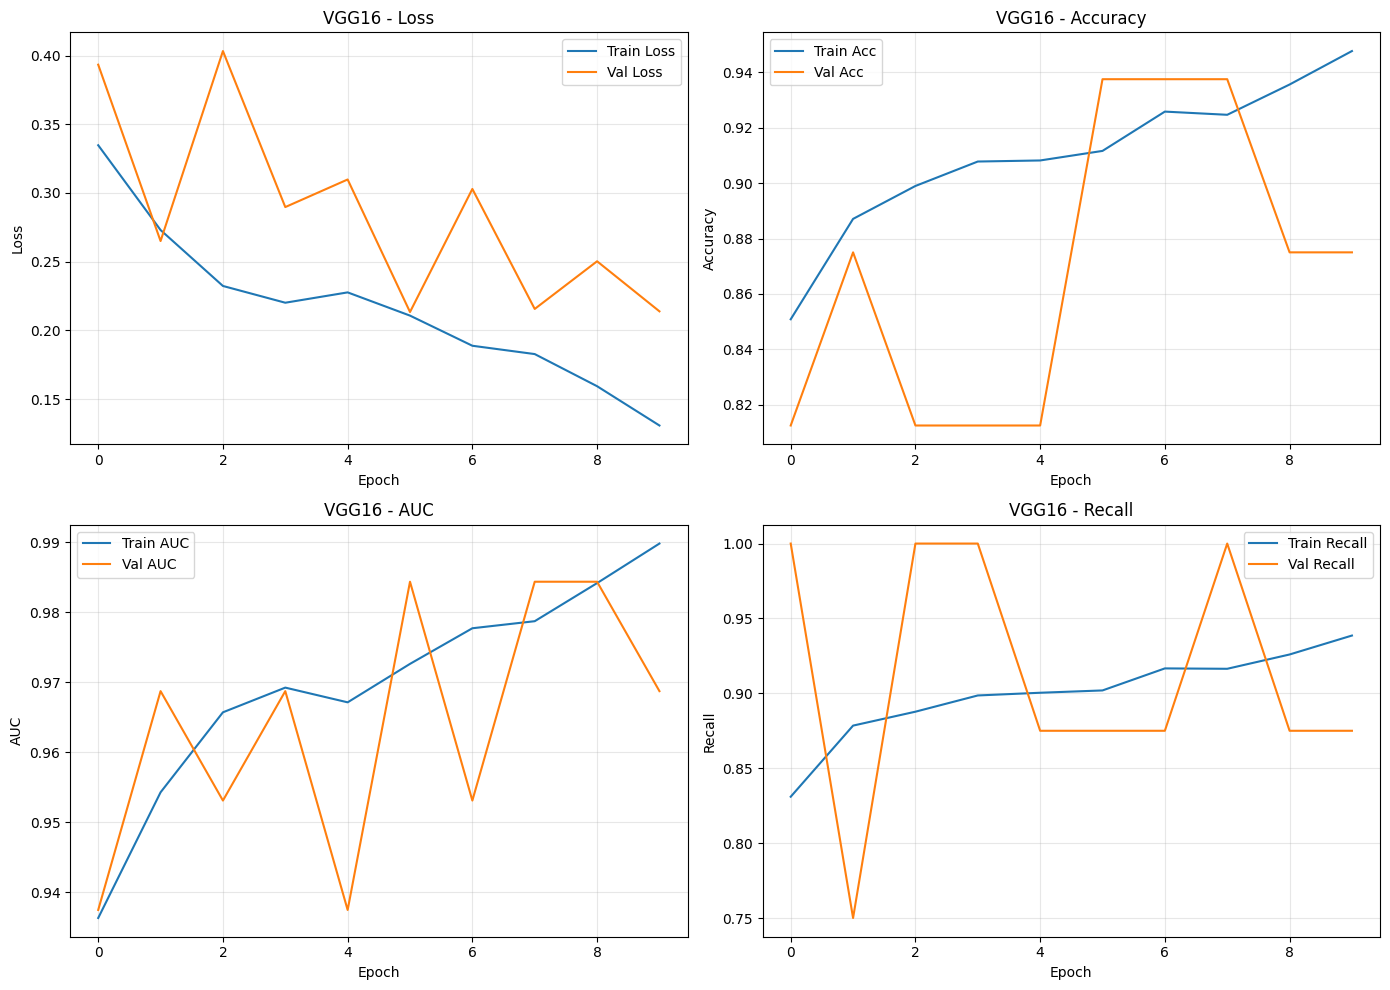


EVALUATING VGG16
624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step

Test Metrics:
  Accuracy:  90.54%
  Precision: 93.21%
  Recall:    91.54%
  AUC:       0.9526

Clinical Metrics:
  Sensitivity: 91.54%
  Specificity: 88.89%

Confusion Matrix:
[[208  26]
 [ 33 357]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.86      0.89      0.88       234
   PNEUMONIA       0.93      0.92      0.92       390

    accuracy                           0.91       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



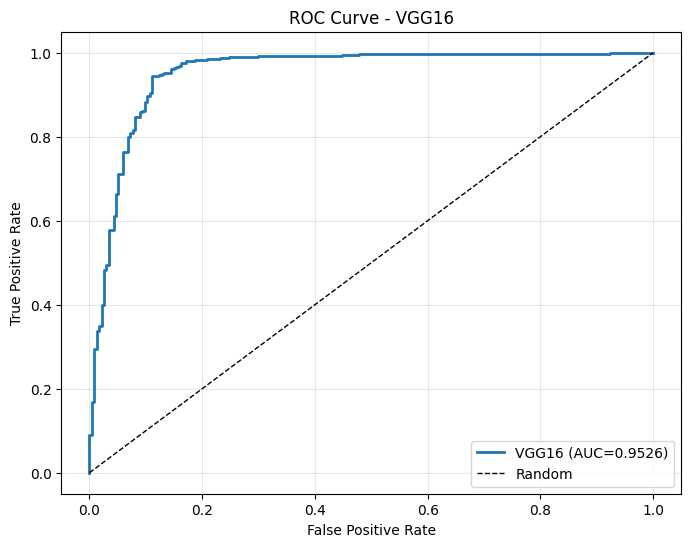

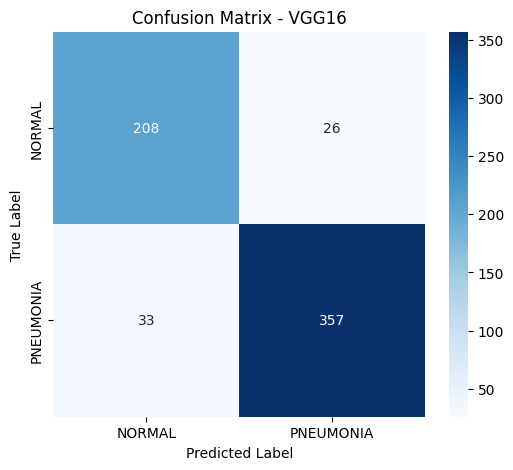

In [17]:
print("\n" + "="*60)
print("TRAINING VGG16")
print("="*60)

vgg16_base = VGG16(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

vgg16_base.trainable = False
vgg16_model = build_transfer_model(vgg16_base, 'VGG16')
vgg16_model = compile_model(vgg16_model, learning_rate=0.001)

print("\nPhase 1: Training top layers...")
history_v1 = vgg16_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=get_callbacks('VGG16_P1'),
    verbose=1
)

print("\nPhase 2: Fine-tuning...")
vgg16_base.trainable = True
for layer in vgg16_base.layers[:-4]:
    layer.trainable = False

vgg16_model = compile_model(vgg16_model, learning_rate=1e-5)

history_v2 = vgg16_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=get_callbacks('VGG16_P2'),
    verbose=1
)

for key in history_v1.history.keys():
    history_v1.history[key].extend(history_v2.history[key])

plot_training_history(history_v1, 'VGG16')
results['VGG16'] = evaluate_model(vgg16_model, test_generator, 'VGG16')


TRAINING RESNET50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Phase 1: Training top layers...
Epoch 1/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 134s 176ms/step - accuracy: 0.7400 - auc: 0.8409 - loss: 0.5258 - precision: 0.9215 - recall: 0.7124 - val_accuracy: 0.5000 - val_auc: 0.6250 - val_loss: 3.7537 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 103s 158ms/step - accuracy: 0.8173 - auc: 0.9006 - loss: 0.4065 - precision: 0.9422 - recall: 0.8034 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 10.1245 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 102s 157ms/step - accuracy: 0.8385 - auc: 0.9187 - loss: 0.3668 - precision: 0.9483 - recall: 0.8248 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 7.8365 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 103s 157ms/step - accuracy: 0.8513 - auc: 0.9323 -

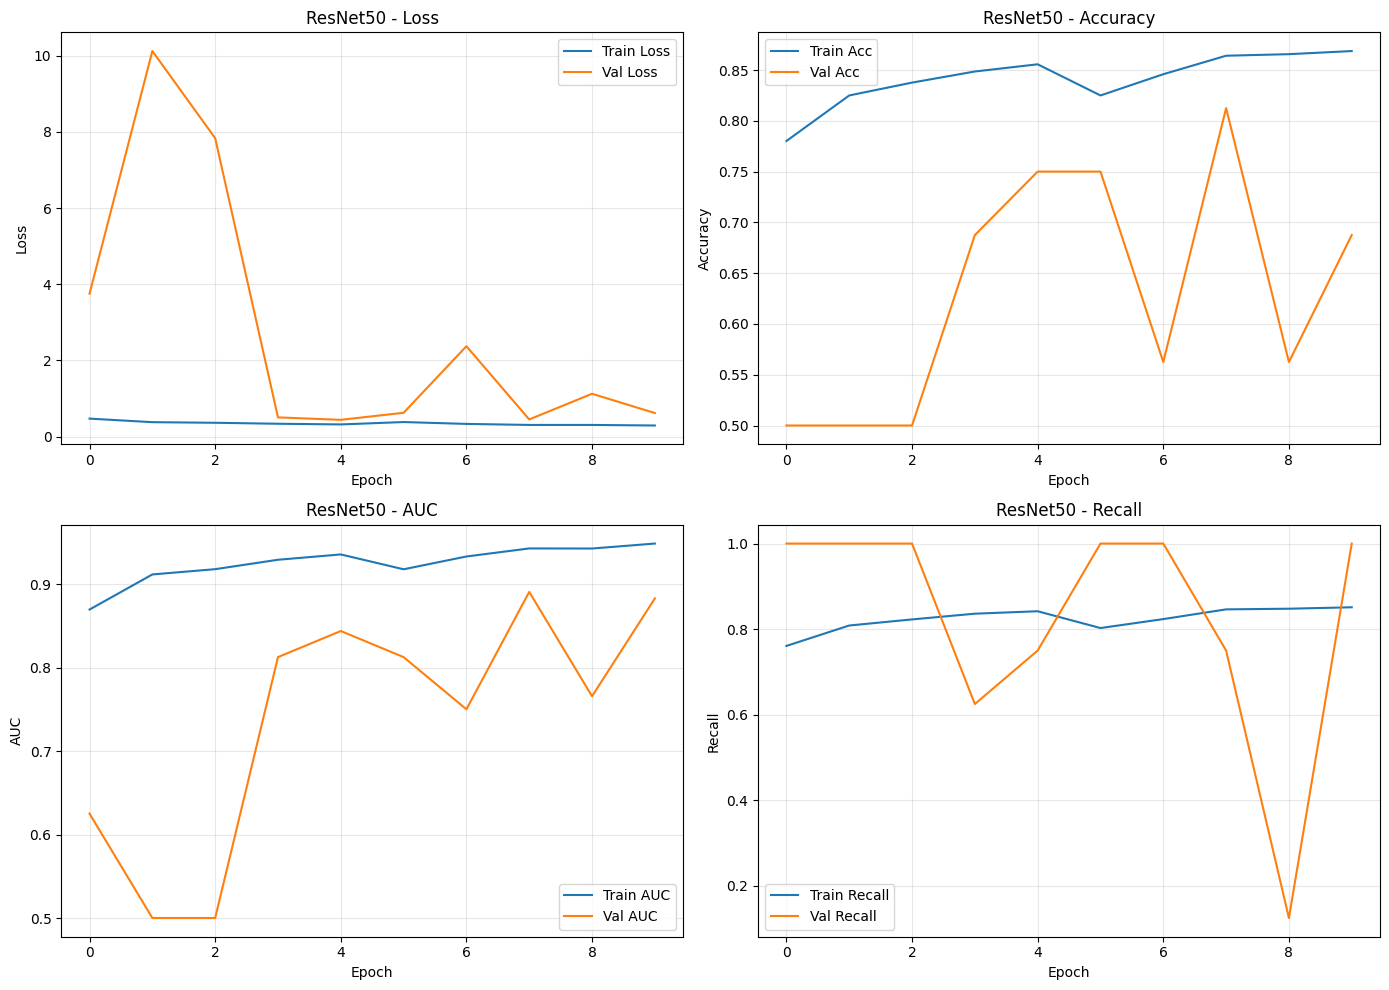


EVALUATING ResNet50
624/624 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step

Test Metrics:
  Accuracy:  63.14%
  Precision: 93.01%
  Recall:    44.36%
  AUC:       0.8984

Clinical Metrics:
  Sensitivity: 44.36%
  Specificity: 94.44%

Confusion Matrix:
[[221  13]
 [217 173]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.50      0.94      0.66       234
   PNEUMONIA       0.93      0.44      0.60       390

    accuracy                           0.63       624
   macro avg       0.72      0.69      0.63       624
weighted avg       0.77      0.63      0.62       624



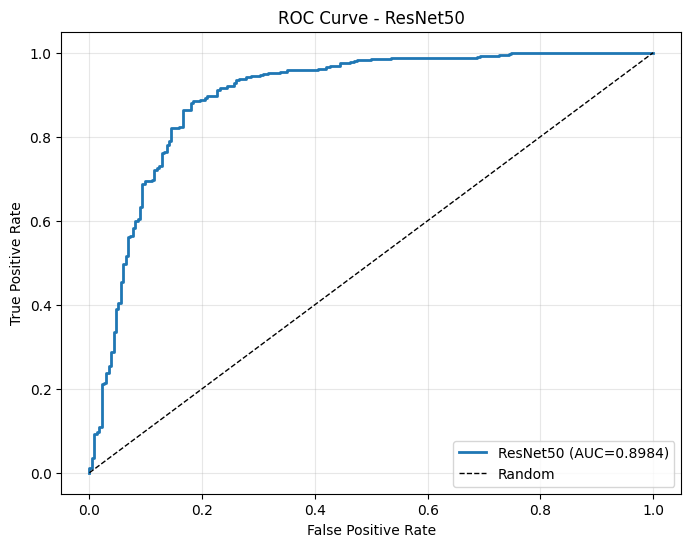

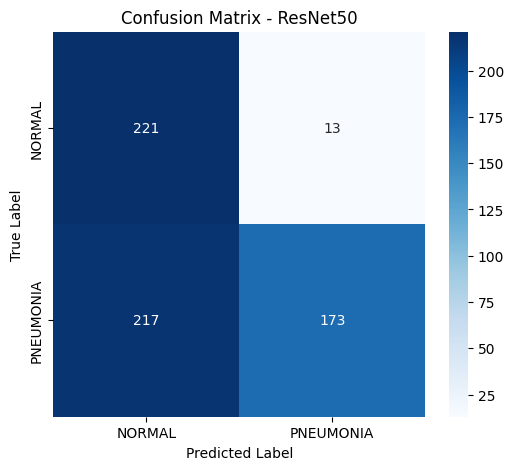

In [18]:
print("\n" + "="*60)
print("TRAINING RESNET50")
print("="*60)

resnet_base = ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

resnet_base.trainable = False
resnet_model = build_transfer_model(resnet_base, 'ResNet50')
resnet_model = compile_model(resnet_model, learning_rate=0.001)

print("\nPhase 1: Training top layers...")
history_r1 = resnet_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=get_callbacks('ResNet50_P1'),
    verbose=1
)

print("\nPhase 2: Fine-tuning...")
resnet_base.trainable = True
for layer in resnet_base.layers[:-20]:
    layer.trainable = False

resnet_model = compile_model(resnet_model, learning_rate=1e-5)

history_r2 = resnet_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=get_callbacks('ResNet50_P2'),
    verbose=1
)

for key in history_r1.history.keys():
    history_r1.history[key].extend(history_r2.history[key])

plot_training_history(history_r1, 'ResNet50')
results['ResNet50'] = evaluate_model(resnet_model, test_generator, 'ResNet50')